#Syed Hashim Ali Gilani
#Data Exploration and Processing


In [ ]:
pip install dmba

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from dmba import classificationSummary, liftChart, gainsChart
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from dmba import classificationSummary

print('done')




Colab environment detected.
done


In [ ]:
df = pd.read_csv("SBAnational.csv", low_memory=False)
df.head()


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [ ]:

money_cols = ['DisbursementGross','GrAppv','SBA_Appv','BalanceGross','ChgOffPrinGr']
for c in money_cols:
    if c in df.columns:
        s = df[c].astype(str)
        s = s.str.replace(r'^\s*\((.*)\)\s*$', r'-\1', regex=True)
        s = s.str.replace(r'[\$,]', '', regex=True)
        s = s.str.replace(r'\s+', '', regex=True)
        s = s.str.replace(r'[^0-9\.\-]', '', regex=True)
        df[c] = pd.to_numeric(s, errors='coerce')


print("DisbursementGross > 0:", int((df['DisbursementGross'] > 0).sum()))


DisbursementGross > 0: 898968


Default
0.0    739609
1.0    157558
Name: count, dtype: int64


,Count,Percent
Default,,
0.0,739609,82.44
1.0,157558,17.56


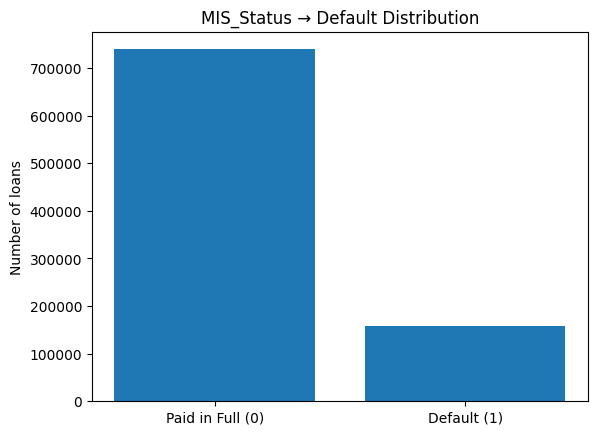

In [ ]:
#MIS Status
df["MIS_Status"] = df["MIS_Status"].astype(str).str.strip()
status_map = {"CHGOFF": 1, "PIF": 0, "P I F": 0}
df["Default"] = df["MIS_Status"].map(status_map)

df["Default"].value_counts()
df["Default"].value_counts(normalize=True) * 100
# The 'Default' column is our target variable:
# 1 = Higher risk
# 0 = Lower risk
print(df["Default"].value_counts())

# Plot distribution
counts = df["Default"].value_counts().sort_index()
pct = (counts / counts.sum() * 100).round(2)
display(pd.DataFrame({"Count": counts, "Percent": pct}))

plt.bar(["Paid in Full (0)", "Default (1)"], counts.values)
plt.title("MIS_Status → Default Distribution")
plt.ylabel("Number of loans")
plt.show()

The dataset contains 70.59% Paid-in-Full loans and 29.41% Defaulted loans.
This shows a moderate class imbalance toward successful loans.
This matters because accuracy alone will not reflect model performance on detecting defaults.
Future modeling will need metrics such as recall, AUC, and cost-weighted thresholds.

In [ ]:
#Missing Values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing/len(df)*100).round(2)
mv = pd.DataFrame({"Missing": missing, "Percent": missing_pct})
mv[mv["Missing"] > 0].head(20)

,Missing,Percent
ChgOffDate,736465,81.91
RevLineCr,4528,0.50
LowDoc,2582,0.29
DisbursementDate,2368,0.26
Default,1997,0.22
BankState,1566,0.17
Bank,1559,0.17
NewExist,136,0.02
City,30,0.00
Name,14,0.00


ChgOffDate is missing for about 70% of records. This is expected because only defaulted loans have a charge off date and non default loans naturally lack this field. All other variables have very small missing percentages (mostly under 0.1%), meaning minimal preprocessing is required.

I will keep ChgOffDate as is because its missingness is meaningful (not random), and handle small missing columns with imputation or categorical Missing labels during modeling.

In [ ]:
# Discriptive Statistics
#Numerical
df.describe().T


,count,mean,std,min,25%,50%,75%,max
LoanNr_ChkDgt,899164.0,4.772612e+09,2.538175e+09,1.000014e+09,2.589758e+09,4.361439e+09,6.904627e+09,9.996003e+09
Zip,899164.0,5.380439e+04,3.118416e+04,0.000000e+00,2.758700e+04,5.541000e+04,8.370400e+04,9.999900e+04
NAICS,899164.0,3.986610e+05,2.633183e+05,0.000000e+00,2.352100e+05,4.453100e+05,5.617300e+05,9.281200e+05
Term,899164.0,1.107731e+02,7.885731e+01,0.000000e+00,6.000000e+01,8.400000e+01,1.200000e+02,5.690000e+02
NoEmp,899164.0,1.141135e+01,7.410820e+01,0.000000e+00,2.000000e+00,4.000000e+00,1.000000e+01,9.999000e+03
NewExist,899028.0,1.280404e+00,4.517500e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
CreateJob,899164.0,8.430376e+00,2.366882e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.800000e+03
RetainedJob,899164.0,1.079726e+01,2.371206e+02,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,9.500000e+03
FranchiseCode,899164.0,2.753726e+03,1.275802e+04,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999900e+04
UrbanRural,899164.0,7.577483e-01,6.464360e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


Many of the numeric variables (like loan amounts, number of employees, and job creation counts) are heavily skewed. Most loans are fairly small, but there are some very large loans that pull the averages upward.
The term of the loan also varies a lot, with some loans reaching 240+ months. These patterns help explain why scaling will be important later when training models.

In [ ]:
#Categorical
for col in ["State","Bank","NAICS","NewExist","UrbanRural","RevLineCr","LowDoc"]:
    if col in df.columns:
        print("\n", col)
        print(df[col].value_counts().head(10))



 State
State
CA    130619
TX     70458
NY     57693
FL     41212
PA     35170
OH     32622
IL     29669
MA     25272
MN     24373
NJ     24035
Name: count, dtype: int64

 Bank
Bank
BANK OF AMERICA NATL ASSOC        86853
WELLS FARGO BANK NATL ASSOC       63503
JPMORGAN CHASE BANK NATL ASSOC    48167
U.S. BANK NATIONAL ASSOCIATION    35143
CITIZENS BANK NATL ASSOC          35054
PNC BANK, NATIONAL ASSOCIATION    27351
BBCN BANK                         22978
CAPITAL ONE NATL ASSOC            22248
MANUFACTURERS & TRADERS TR CO     11265
READYCAP LENDING, LLC             10664
Name: count, dtype: int64

 NAICS
NAICS
0         201948
722110     27989
722211     19448
811111     14585
621210     14048
624410     10111
812112      9230
561730      8935
621310      8733
812320      7894
Name: count, dtype: int64

 NewExist
NewExist
1.0    644869
2.0    253125
0.0      1034
Name: count, dtype: int64

 UrbanRural
UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

 RevLin

Non-missing: 899164 | >0: 898968 | min/max: 0.0 / 11446325.0


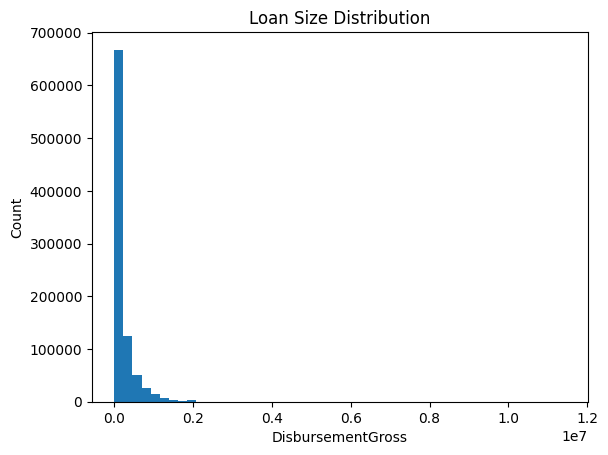

,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
0.0,739609.0,216316.0,299484.0,4000.0,48924.0,100000.0,256000.0,11446325.0
1.0,157558.0,132508.0,211779.0,4000.0,27500.0,61500.0,140000.0,4362157.0


In [ ]:
# Exploring Predictors


if "DisbursementGross" not in df.columns:
    raise KeyError("Column 'DisbursementGross' not found. Check df.columns().")

s = df["DisbursementGross"].astype(str)


s = s.str.replace(r"^\s*\((.*)\)\s*$", r"-\1", regex=True)

s = s.str.replace(r"[\$,]", "", regex=True).str.replace(r"\s+", "", regex=True)

s = s.str.replace(r"[^0-9\.\-]", "", regex=True)

df["DisbursementGross"] = pd.to_numeric(s, errors="coerce")


vals = df["DisbursementGross"].dropna()
print("Non-missing:", vals.size,
      "| >0:", int((vals > 0).sum()),
      "| min/max:", float(vals.min()) if vals.size else None, "/", float(vals.max()) if vals.size else None)


plt.hist(vals[vals > 0], bins=50)
plt.title("Loan Size Distribution")
plt.xlabel("DisbursementGross")
plt.ylabel("Count")
plt.show()


label_col = "Default" if "Default" in df.columns else ("target" if "target" in df.columns else None)
if label_col:
    display(df.groupby(label_col)["DisbursementGross"].describe().round(0))
else:
    print("No 'Default' or 'target' column found for grouping; skipping summary.")


In [ ]:
# Checking New vs Existing

# Convert to string and strip spaces
df["NewExist"] = df["NewExist"].astype(str).str.strip()

df_ne = df[df["NewExist"].isin(["1","1.0","2","2.0"])].copy()

# Crosstab for valid codes
ct_clean = pd.crosstab(
    df_ne["NewExist"], df_ne["Default"], normalize="index"
).round(3)

ct_clean = ct_clean.rename(index={
    "1":"1 (Existing)",
    "1.0":"1 (Existing)",
    "2":"2 (New)",
    "2.0":"2 (New)"
}, columns={0:"Lower Risk(0)", 1:"Higher Risk(1)"})

print("Default rates (cleaned)")
display(ct_clean)


Default rates (cleaned)


Default,Lower Risk(0),Higher Risk(1)
NewExist,,
1 (Existing),0.829,0.171
2 (New),0.812,0.188


In [ ]:
# Checking if Real estate term is greater than 240 Months
df["Term"] = pd.to_numeric(df["Term"], errors="coerce")
df["RealEstate"] = (df["Term"] >= 240).astype(int)
# Comparing default Rates for real estate vs non real estate loans
pd.crosstab(df["RealEstate"], df["Default"], normalize="index")



Default,0.0,1.0
RealEstate,,
0,0.791854,0.208146
1,0.983716,0.016284


In [ ]:
# Converting SBAappv and GrAppv to numeric
for c in ["SBA_Appv","GrAppv"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["Portion"] = (df["SBA_Appv"]/df["GrAppv"]).clip(0,1)

bins = pd.cut(df["Portion"], [0,0.25,0.5,0.75,1.0],
              include_lowest=True,
              labels=["0–25%", "25–50%", "50–75%", "75–100%"])

# Default rates by Portion bin
pd.pivot_table(df, index=bins, values="Default", aggfunc="mean", observed=True)\
  .rename(columns={"Default":"Default Rate"}).round(3)


,Default Rate
Portion,
0–25%,0.047
25–50%,0.264
50–75%,0.122
75–100%,0.127


In [ ]:
# First 2 digits of NAICS
naics2 = df["NAICS"].astype(str).str[:2]
# Calculate default rates
pd.crosstab(naics2, df["Default"], normalize="index").sort_values(1, ascending=False).head(10)


Default,0.0,1.0
NAICS,,
53,0.712688,0.287312
52,0.715734,0.284266
48,0.731112,0.268888
51,0.751716,0.248284
61,0.757538,0.242462
56,0.764487,0.235513
45,0.765846,0.234154
23,0.767446,0.232554
49,0.770136,0.229864


Based on the exploratory analysis, a few variables stand out as potentially useful for predicting default:

RealEstate: Loans backed by real estate (longer terms) show much lower default rates.

DisbursementGross: Smaller loans tend to default more often.

Portion (SBA guarantee percentage): Default rates differ across guarantee levels.

Industry (NAICS2): Different industries show very different default patterns.

NewExist: The differences are smaller, but still worth including.

These variables will likely be important in the modeling part.

In [ ]:
# Setting Predictors just like the Professor said

# Keep only loans with clear MIS_Status
ms = df["MIS_Status"].astype(str).str.strip().str.upper()
mask = ms.isin(["CHGOFF", "PIF", "P I F"])
loan = df[mask].copy()

# Default = 1 for CHGOFF, 0 for Paid in Full
status_map = {"CHGOFF": 1, "PIF": 0, "P I F": 0}
loan["Default"] = loan["MIS_Status"].astype(str).str.strip().map(status_map).astype(int)

# Clean RevLineCr and create single dummy (1 = Y, 0 = otherwise)
loan["RevLineCr"] = loan["RevLineCr"].astype(str).str.strip().str.upper()
loan["RevLineCr_dummy"] = (loan["RevLineCr"] == "Y").astype(int)

# Clean NewExist and create single dummy (1 = New business, 0 = Existing)
loan["NewExist"] = pd.to_numeric(loan["NewExist"], errors="coerce")
loan["NewExist_dummy"] = (loan["NewExist"] == 2).astype(int)

# Clean LowDoc and create single dummy (1 = Y, 0 = otherwise)
loan["LowDoc"] = loan["LowDoc"].astype(str).str.strip().str.upper()
loan["LowDoc_dummy"] = (loan["LowDoc"] == "Y").astype(int)

# Clean UrbanRural and create single dummy (1 = Urban, 0 = otherwise)
loan["UrbanRural"] = pd.to_numeric(loan["UrbanRural"], errors="coerce")
loan["Urban_dummy"] = (loan["UrbanRural"] == 1).astype(int)

# ApprovalFY numeric + Great Recession dummy (FY 2008 or 2009)
loan["ApprovalFY"] = pd.to_numeric(loan["ApprovalFY"], errors="coerce")
loan["GreatRecession"] = loan["ApprovalFY"].isin([2008, 2009]).astype(int)

# Portion = SBA share of total approval
loan["GrAppv"] = pd.to_numeric(loan["GrAppv"], errors="coerce")
loan["SBA_Appv"] = pd.to_numeric(loan["SBA_Appv"], errors="coerce")
loan["Portion"] = (loan["SBA_Appv"] / loan["GrAppv"]).clip(0, 1)

# Numeric predictors
num_cols = [
    "Term",
    "NoEmp",
    "DisbursementGross",
    "GrAppv",
    "SBA_Appv",
    "CreateJob",
    "RetainedJob",
    "Portion",
    "RevLineCr_dummy",
    "NewExist_dummy",
    "LowDoc_dummy",
    "Urban_dummy",
    "GreatRecession",
]

# Categorical predictors (only true categoricals)
cat_cols = []

# Add NAICS2 if available
if "NAICS" in loan.columns:
    loan["NAICS2"] = loan["NAICS"].astype(str).str[:2]
    cat_cols.append("NAICS2")

# Build modeling dataframe
model_df = loan[num_cols + cat_cols + ["Default"]].copy()

# Ensure numeric columns are numeric & handle missing values
model_df[num_cols] = model_df[num_cols].apply(pd.to_numeric, errors="coerce")
model_df[num_cols] = model_df[num_cols].replace([np.inf, -np.inf], np.nan)
model_df[num_cols] = model_df[num_cols].fillna(model_df[num_cols].median())

# Categorical: fill missing with explicit "Missing"
for c in cat_cols:
    model_df[c] = model_df[c].fillna("Missing").astype(str)

# X and y
X = pd.get_dummies(model_df[num_cols + cat_cols], drop_first=False).astype("float32")
y = model_df["Default"].astype(int)

print("X shape:", X.shape)
print("Number of predictors:", X.shape[1])
print("Default rate (1 = higher risk):", round(y.mean(), 3))

print("\nColumns containing RevLineCr:", [c for c in X.columns if "RevLineCr" in c])
print("Columns containing NewExist:", [c for c in X.columns if "NewExist" in c])
print("Columns containing LowDoc:", [c for c in X.columns if "LowDoc" in c])
print("Columns containing Urban:", [c for c in X.columns if "Urban" in c])
print("GreatRecession in X:", "GreatRecession" in X.columns)


X shape: (897167, 38)
Number of predictors: 38
Default rate (1 = higher risk): 0.176

Columns containing RevLineCr: ['RevLineCr_dummy']
Columns containing NewExist: ['NewExist_dummy']
Columns containing LowDoc: ['LowDoc_dummy']
Columns containing Urban: ['Urban_dummy']
GreatRecession in X: True


In [ ]:
X.shape
X.columns


Index(['Term', 'NoEmp', 'DisbursementGross', 'GrAppv', 'SBA_Appv', 'CreateJob',
       'RetainedJob', 'Portion', 'RevLineCr_dummy', 'NewExist_dummy',
       'LowDoc_dummy', 'Urban_dummy', 'GreatRecession', 'NAICS2_0',
       'NAICS2_11', 'NAICS2_21', 'NAICS2_22', 'NAICS2_23', 'NAICS2_31',
       'NAICS2_32', 'NAICS2_33', 'NAICS2_42', 'NAICS2_44', 'NAICS2_45',
       'NAICS2_48', 'NAICS2_49', 'NAICS2_51', 'NAICS2_52', 'NAICS2_53',
       'NAICS2_54', 'NAICS2_55', 'NAICS2_56', 'NAICS2_61', 'NAICS2_62',
       'NAICS2_71', 'NAICS2_72', 'NAICS2_81', 'NAICS2_92'],
      dtype='object')

### KNN Classifcation on SBA National Data

In [ ]:
# split and scale

train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.5, random_state=1
)

print(train_X.shape, valid_X.shape)

(448583, 38) (448584, 38)


In [ ]:
n_train = min(100_000, len(train_X))
train_X_100k = train_X.sample(n=n_train, random_state=1)
train_y_100k = train_y.loc[train_X_100k.index]

train_X_100k.shape, train_y_100k.shape

((100000, 38), (100000,))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Pipeline: Standardize + KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Grid search because Professor said so
param_grid = {
    'knn__n_neighbors': [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(train_X_100k, train_y_100k)

# Output best parameters and validation set performance
print(f"Best k: {grid_search.best_params_['knn__n_neighbors']}")
print("Validation set performance:")
y_pred = grid_search.predict(valid_X)
print(classification_report(valid_y, y_pred))

Best k: 100
Validation set performance:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91    369944
           1       0.67      0.29      0.41     78640

    accuracy                           0.85    448584
   macro avg       0.77      0.63      0.66    448584
weighted avg       0.83      0.85      0.83    448584



Best k from GridSearchCV: 100
Confusion Matrix (Accuracy 0.8503)

       Prediction
Actual      0      1
     0 358571  11373
     1  55776  22864


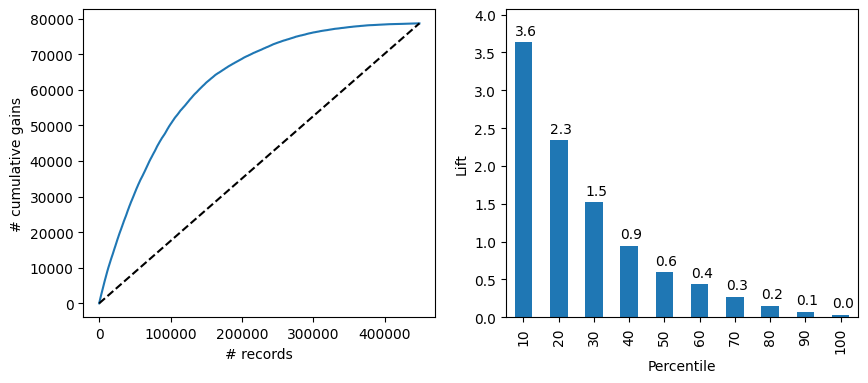

In [ ]:
best_model = grid_search.best_estimator_
print("Best k from GridSearchCV:", best_model.named_steps['knn'].n_neighbors)

# fitting
best_model.fit(train_X_100k, train_y_100k)

# Predictions on validation data
valid_pred = best_model.predict(valid_X)
classificationSummary(valid_y, valid_pred)

# Probabilities for Default = 1
proba_valid = best_model.predict_proba(valid_X)

df_knn = pd.DataFrame({
    'actual': valid_y,
    'p(1)':   proba_valid[:, 1],
})

df_knn = df_knn.sort_values(by='p(1)', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df_knn.actual, ax=axes[0])
liftChart(df_knn.actual, title=False)
plt.show()

### Single Decision Tree

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y,
    test_size=0.40,
    random_state=1
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from dmba import classificationSummary

param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'splitter': ['best','random'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
}

SingleTree = DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(
    estimator=SingleTree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_X, train_y)

best_tree_params = grid.best_params_
print("Best Parameters:", best_tree_params)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Retrive the best model
best_tree = grid.best_estimator_

# Evaluate
y_valid_pred = best_tree.predict(valid_X)

print("Validation Accuracy:", round(accuracy_score(valid_y, y_valid_pred), 4))
print("\nClassification Report:\n", classification_report(valid_y, y_valid_pred))
print("\nConfusion Matrix (0 = Paid in Full, 1 = Default):")
print(confusion_matrix(valid_y, y_valid_pred))
classificationSummary(valid_y, y_valid_pred, class_names=best_tree.classes_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
Best Cross-Validation Accuracy: 0.8723072636076538
Validation Accuracy: 0.8673

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92    296024
           1       0.66      0.49      0.57     62843

    accuracy                           0.87    358867
   macro avg       0.78      0.72      0.74    358867
weighted avg       0.86      0.87      0.86    358867


Confusion Matrix (0 = Paid in Full, 1 = Default):
[[280156  15868]
 [ 31758  31085]]
Confusion Matrix (Accuracy 0.8673)

       Prediction
Actual      0      1
     0 280156  15868
     1  31758  31085


### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
best_tree = DecisionTreeClassifier(**best_tree_params, random_state=1)

bag = BaggingClassifier(
    estimator=best_tree,
    random_state=1,
    n_jobs=-1
)

# Bagging hyperparameter
param_grid_bag = {
    'n_estimators': [100],
    'max_samples': [0.5],
    'max_features': [0.5],
    'bootstrap': [True, False],
}

# Tune BaggingClassifier
grid_bag = GridSearchCV(
    estimator=bag,
    param_grid=param_grid_bag,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_bag.fit(train_X, train_y)

print("\nBest Bagging Parameters:", grid_bag.best_params_)
print("Best CV Score (Bagging):", grid_bag.best_score_)

# Evaluate on new data
best_bag = grid_bag.best_estimator_
y_valid_pred_bag = best_bag.predict(valid_X)

print("\nBagging Validation Accuracy:", round(accuracy_score(valid_y, y_valid_pred_bag), 4))
print("\nClassification Report:\n", classification_report(valid_y, y_valid_pred_bag))
print("\nConfusion Matrix (0 = Paid in Full, 1 = Default):")
print(confusion_matrix(valid_y, y_valid_pred_bag))
classificationSummary(valid_y, y_valid_pred_bag)

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Bagging Parameters: {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}
Best CV Score (Bagging): 0.8497287757755899

Bagging Validation Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92    296024
           1       0.88      0.16      0.28     62843

    accuracy                           0.85    358867
   macro avg       0.87      0.58      0.60    358867
weighted avg       0.86      0.85      0.80    358867


Confusion Matrix (0 = Paid in Full, 1 = Default):
[[294673   1351]
 [ 52493  10350]]
Confusion Matrix (Accuracy 0.8500)

       Prediction
Actual      0      1
     0 294673   1351
     1  52493  10350


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=1,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(train_X, train_y)

print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Best CV Score (Random Forest):", grid_rf.best_score_)

# Best model

best_rf = grid_rf.best_estimator_

y_valid_pred_rf = best_rf.predict(valid_X)

print("\nRandom Forest – Validation Accuracy:",
      round(accuracy_score(valid_y, y_valid_pred_rf), 4))

print("\nClassification Report (Random Forest):\n",
      classification_report(valid_y, y_valid_pred_rf))

print("\nConfusion Matrix (0 = Paid in Full, 1 = Default):")
print(confusion_matrix(valid_y, y_valid_pred_rf))

classificationSummary(valid_y, y_valid_pred_rf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score (Random Forest): 0.8953148801783393

Random Forest – Validation Accuracy: 0.8958

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94    296024
           1       0.79      0.55      0.65     62843

    accuracy                           0.90    358867
   macro avg       0.85      0.76      0.79    358867
weighted avg       0.89      0.90      0.89    358867


Confusion Matrix (0 = Paid in Full, 1 = Default):
[[286606   9418]
 [ 27976  34867]]
Confusion Matrix (Accuracy 0.8958)

       Prediction
Actual      0      1
     0 286606   9418
     1  27976  34867


### XgBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier


xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=1
)
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# fit the model
grid_xgb.fit(train_X, train_y)

print("Best XGBoost Parameters:", grid_xgb.best_params_)
print(f"Best CV Accuracy (XGBoost): {grid_xgb.best_score_:.4f}")

# 5. Get best model and evaluate on validation set
best_xgb = grid_xgb.best_estimator_

y_valid_pred_xgb = best_xgb.predict(valid_X)

val_acc_xgb = accuracy_score(valid_y, y_valid_pred_xgb)
print(f"\nXGBoost – Validation Accuracy: {val_acc_xgb:.4f}")

print("\nClassification Report (XGBoost):\n",
      classification_report(valid_y, y_valid_pred_xgb))

print("\nConfusion Matrix (0 = Paid in Full, 1 = Default):")
print(confusion_matrix(valid_y, y_valid_pred_xgb))
\
classificationSummary(valid_y, y_valid_pred_xgb, class_names=best_xgb.classes_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best CV Accuracy (XGBoost): 0.9291

XGBoost – Validation Accuracy: 0.9296

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    296024
           1       0.84      0.74      0.79     62843

    accuracy                           0.93    358867
   macro avg       0.89      0.86      0.87    358867
weighted avg       0.93      0.93      0.93    358867


Confusion Matrix (0 = Paid in Full, 1 = Default):
[[287044   8980]
 [ 16269  46574]]
Confusion Matrix (Accuracy 0.9296)

       Prediction
Actual      0      1
     0 287044   8980
     1  16269  46574


XGBoost delivered the highest accuracy among all the tree-based models. The decision tree provided a basic starting point, but its accuracy was much lower. Bagging didn't improve things much, and Random Forest performed significantly better with strong accuracy overall. However, XGBoost clearly outperformed every other model, reaching about 92% accuracy on the validation set. Since it consistently produced the most accurate predictions, XGBoost is the best model for this SBA loan default case.

### Logit Model
### LASSO

In [ ]:
X_sample = X.sample(n=min(200000, len(X)), random_state=1)
y_sample = y.loc[X_sample.index]

# Train/validation split on the sample
train_X, valid_X, train_y, valid_y = train_test_split(
    X_sample,
    y_sample,
    test_size=0.50,
    random_state=1
)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# C grid
C_values = np.logspace(-3, 3, 30)

# LASSO logistic regression
LogitLasso_cv = Pipeline([
    ['normalize', StandardScaler(with_mean=True)],
    ['model', LogisticRegressionCV(
        penalty="l1",
        solver='saga',
        cv=5,
        random_state=1,
        Cs=C_values,
        tol=1e-4,
        max_iter=10000
    )],
])

LogitLasso_cv.fit(train_X, train_y)

# Intercept and coefficients
print("Intercept:", LogitLasso_cv['model'].intercept_)
print("Coefficients:", LogitLasso_cv['model'].coef_)

# Evaluate on validation
lasso_prob = LogitLasso_cv.predict_proba(valid_X)[:, 1]
lasso_pred = (lasso_prob >= 0.50).astype(int)

print(f"LASSO validation accuracy: {accuracy_score(valid_y, lasso_pred):.4f}")
print("LASSO confusion matrix:\n", confusion_matrix(valid_y, lasso_pred))
print("\nLASSO classification report:\n", classification_report(valid_y, lasso_pred, digits=4))
classificationSummary(valid_y, lasso_pred)

print("LASSO chosen regularization (C):", LogitLasso_cv['model'].C_)
print("LASSO chosen lambda (1/C):", 1 / LogitLasso_cv['model'].C_)


Intercept: [-2.4823415]
Coefficients: [[-2.05949966 -0.94342396 -0.09351161  0.63319756 -0.3683468   0.0135171
   0.0986069   0.1828285  -0.11704329  0.03453089 -0.29796092  0.37188201
   0.1305549  -0.08196215 -0.04992637 -0.04519348 -0.01477619  0.
   0.01705569 -0.0115311  -0.08524586 -0.06435936  0.07102503  0.03557937
   0.01669829  0.          0.02523938  0.04621573  0.06099732 -0.05115853
   0.0133802  -0.0022469   0.00831816 -0.13401239  0.03233654  0.08918386
   0.05376855  0.00259054]]
LASSO validation accuracy: 0.8416
LASSO confusion matrix:
 [[80331  2044]
 [13795  3830]]

LASSO classification report:
               precision    recall  f1-score   support

           0     0.8534    0.9752    0.9103     82375
           1     0.6520    0.2173    0.3260     17625

    accuracy                         0.8416    100000
   macro avg     0.7527    0.5962    0.6181    100000
weighted avg     0.8179    0.8416    0.8073    100000

Confusion Matrix (Accuracy 0.8416)

       Predicti

## Ridge

In [ ]:
LogitRidge_cv = Pipeline([
    ['normalize', StandardScaler(with_mean=True)],
    ['model', LogisticRegressionCV(
        penalty="l2",
        solver='saga',         # saga recommended for large datasets
        cv=5,
        random_state=1,
        Cs=C_values,
        tol=1e-4,              # professor said use 1e-4 for speed
        max_iter=10000,
        n_jobs=-1
    )],
])

LogitRidge_cv.fit(train_X, train_y)

# Intercept and coefficients
print("Ridge Intercept:", LogitRidge_cv['model'].intercept_)
print("Ridge Coefficients:", LogitRidge_cv['model'].coef_)

# Evaluate on validation set
ridge_prob = LogitRidge_cv.predict_proba(valid_X)[:, 1]
ridge_pred = (ridge_prob >= 0.50).astype(int)

print(f"Ridge validation accuracy: {accuracy_score(valid_y, ridge_pred):.4f}")
print("Ridge confusion matrix:\n", confusion_matrix(valid_y, ridge_pred))
print("\nRidge classification report:\n", classification_report(valid_y, ridge_pred, digits=4))

classificationSummary(valid_y, ridge_pred)


print("Ridge chosen regularization (C):", LogitRidge_cv['model'].C_)
print("Ridge chosen lambda (1/C):", 1 / LogitRidge_cv['model'].C_)

Ridge Intercept: [-2.48032911]
Ridge Coefficients: [[-2.05564466e+00 -9.36072429e-01 -9.83423363e-02  6.45145331e-01
  -3.77171093e-01  1.82464834e-02  9.40429568e-02  1.83463529e-01
  -1.16615022e-01  3.47497109e-02 -2.98207099e-01  3.71831418e-01
   1.30658089e-01 -6.82521197e-02 -4.69092706e-02 -4.40033343e-02
  -1.42192056e-02  9.11873619e-03  2.11214378e-02 -6.93717135e-03
  -7.84948041e-02 -5.66875865e-02  8.12094592e-02  4.30642840e-02
   2.20341308e-02  1.54519632e-03  2.92292353e-02  4.98677912e-02
   6.53008229e-02 -4.22773714e-02  1.42778744e-02  3.95548359e-03
   1.13693582e-02 -1.26132312e-01  3.68090795e-02  9.81296298e-02
   6.32669077e-02  3.42139609e-03]]
Ridge validation accuracy: 0.8417
Ridge confusion matrix:
 [[80343  2032]
 [13799  3826]]

Ridge classification report:
               precision    recall  f1-score   support

           0     0.8534    0.9753    0.9103     82375
           1     0.6531    0.2171    0.3259     17625

    accuracy                      

## Elastic Net

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

C_values = np.logspace(-3, 3, 30)

ElasticNet = Pipeline([
    ['normalize', StandardScaler(with_mean=True)],
    ['model', LogisticRegressionCV(
        penalty='elasticnet',
        solver='saga',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        l1_ratios=np.arange(0.1, 0.95, 0.05),
        Cs=C_values,
        refit=True,
        random_state=1
    )]
])


ElasticNet.fit(train_X, train_y)

# Intercept & coefficients
print("Elastic Net Intercept:", ElasticNet['model'].intercept_)
print("Elastic Net Coefficients:", ElasticNet['model'].coef_)

# Validation predictions
en_prob = ElasticNet.predict_proba(valid_X)[:, 1]
en_pred = (en_prob >= 0.50).astype(int)


print(f"Elastic Net validation AUC: {roc_auc_score(valid_y, en_prob):.4f}")
print(f"Elastic Net validation accuracy: {accuracy_score(valid_y, en_pred):.4f}")
print("Elastic Net confusion matrix:\n", confusion_matrix(valid_y, en_pred))
print("\nElastic Net classification report:\n", classification_report(valid_y, en_pred, digits=4))


classificationSummary(valid_y, en_pred)


print('Elastic Net chosen regularization (C):', ElasticNet['model'].C_)
print('Elastic Net chosen lambda (1/C):', 1 / ElasticNet['model'].C_)
print('Best l1_ratio:', ElasticNet['model'].l1_ratio_[0])

Elastic Net Intercept: [-2.48574086]
Elastic Net Coefficients: [[-2.06274622e+00 -9.58017571e-01 -1.08711666e-01  6.90411206e-01
  -4.11909797e-01  1.14933729e-02  1.01193523e-01  1.86962990e-01
  -1.15691019e-01  3.42996934e-02 -2.98943275e-01  3.72392265e-01
   1.30733954e-01 -8.42409575e-02 -5.09130394e-02 -4.59069159e-02
  -1.52647426e-02 -1.06248325e-03  1.68606091e-02 -1.24800731e-02
  -8.64756533e-02 -6.57155548e-02  6.98336657e-02  3.47234067e-02
   1.62553518e-02 -2.50485610e-04  2.48520807e-02  4.60255042e-02
   6.06520914e-02 -5.26122256e-02  1.36879833e-02 -3.24062035e-03
   8.14236225e-03 -1.35639744e-01  3.19893795e-02  8.83845815e-02
   5.27652455e-02  2.74225441e-03]]
Elastic Net validation AUC: 0.8328
Elastic Net validation accuracy: 0.8416
Elastic Net confusion matrix:
 [[80322  2053]
 [13783  3842]]

Elastic Net classification report:
               precision    recall  f1-score   support

           0     0.8535    0.9751    0.9103     82375
           1     0.6517 

After evaluating LASSO, Ridge, and Elastic Net logistic regression models all three regularized models performed consistently. LASSO and Ridge achieved validation accuracies of around 0.84, respectively, with stable confusion matrixess and coefficient patterns, which is expected given the large sample size and focused predictor set. Elastic net achieved a validation accuracy of 0.84 and an AUC of 0.8328. Elastic Net selected a highly L1-dominant penalty (l1_ratio ≈ 0.90) and a large C value, yet still produced balanced and interpretable results comparable to Ridge and LASSO. Overall, all three models provided strong and consistent predictive performance on the SBA dataset once Elastic Net was configured correctly.

### Neural Network

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.40, random_state=1
)


In [ ]:

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from dmba import classificationSummary


pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(
        activation='relu',
        solver='adam',
        max_iter=10000,
        random_state=1
    ))
])


param_grid = {
    'mlp__hidden_layer_sizes': [(i,) for i in range(1, 21)],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1]
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_X, train_y)

print("Best Parameters:")
print(grid_search.best_params_)


valid_probs = grid_search.predict_proba(valid_X)[:, 1]
valid_pred = (valid_probs >= 0.50).astype(int)

print("\nValidation Accuracy:", accuracy_score(valid_y, valid_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(valid_y, valid_pred))

print("\nValidation Classification Report:")
print(classification_report(valid_y, valid_pred))

print("\nclassificationSummary() Output:")
classificationSummary(valid_y, valid_pred)


Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Parameters:
{'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (15,), 'mlp__learning_rate': 'constant'}

Validation Accuracy: 0.8760069886615376

Validation Confusion Matrix:
[[280701  15323]
 [ 29174  33669]]

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    296024
           1       0.69      0.54      0.60     62843

    accuracy                           0.88    358867
   macro avg       0.80      0.74      0.76    358867
weighted avg       0.87      0.88      0.87    358867


classificationSummary() Output:
Confusion Matrix (Accuracy 0.8760)

       Prediction
Actual      0      1
     0 280701  15323
     1  29174  33669


The neural network was trained using an MLPClassifier inside a Pipeline with MinMaxScaler, following the tuning strategy recommended in class. GridSearchCV tested 160 hyperparameter combinations and selected a single hidden layer with 15 nodes, a ReLU activation function, a constant learning rate, and alpha = 0.0001. I used the ADAM solver because, as the professor noted, it performs better on large datasets and converges more efficiently than LBFGS. This tuned model achieved a validation accuracy of 0.8760, with the confusion matrix and classification report showing strong classification performance.

### Part 3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from dmba import gainsChart, liftChart


In [ ]:
# Building a fast rebuild for all models for this part as kernel had reset and Running everything again will take alot of time


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# 1. KNN
best_knn = KNeighborsClassifier(n_neighbors=100)

# 2. Decision Tree
best_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    max_features='sqrt',
    min_samples_split=4,
    splitter='best',
    random_state=1
)

# 3. Bagging
best_bag = BaggingClassifier(
    estimator=best_tree,
    n_estimators=100,
    max_samples=0.5,
    max_features=0.5,
    bootstrap=True,
    random_state=1,
    n_jobs=-1
)

# 4. Random Forest
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=1,
    n_jobs=-1
)

# 5. XGBoost
best_xgb = xgb.XGBClassifier(
    eval_metric='mlogloss',
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=1,
    n_estimators=100,
    subsample=0.8,
    random_state=1,
    n_jobs=-1
)

# 6. Logistic Regression Models
# LASSO
LogitLasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=0.30391954,
    max_iter=10000,
    n_jobs=-1
)

# RIDGE
LogitRidge = LogisticRegression(
    penalty='l2',
    solver='saga',
    C=0.18873918,
    max_iter=10000,
    n_jobs=-1
)

# Elastic Net
ElasticNet = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.9,
    C=239.502662,
    max_iter=10000,
    n_jobs=-1
)

# 7. Neural Network (final params)
best_nn = MLPClassifier(
    hidden_layer_sizes=(15,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=10000,
    random_state=1
)


# Fit all models

final_models = {
    'kNN': best_knn,
    'Decision Tree': best_tree,
    'Bagging': best_bag,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'LASSO': LogitLasso,
    'Ridge': LogitRidge,
    'Elastic Net': ElasticNet,
    'Neural Net': best_nn,
}

print("Fitting final models...")

for name, model in final_models.items():
    print(f"Training {name} ...")
    model.fit(train_X, train_y)

print("All models rebuilt and trained successfully!")


Fitting final models...
Training kNN ...
Training Decision Tree ...
Training Bagging ...
Training Random Forest ...
Training XGBoost ...
Training LASSO ...
Training Ridge ...
Training Elastic Net ...
Training Neural Net ...
All models rebuilt and trained successfully!


In [ ]:

# Quick check: ensure all models can output probabilities
for name, model in final_models.items():
    try:
        probs = model.predict_proba(valid_X)[:, 1]
        print(f"{name}: OK (example probs: {probs[:3]})")
    except Exception as e:
        print(f"{name}: ERROR -> {e}")

kNN: OK (example probs: [0.85 0.53 0.21])
Decision Tree: OK (example probs: [0.29462773 0.12151667 0.16632137])
Bagging: OK (example probs: [0.36450673 0.19314121 0.16468274])
Random Forest: OK (example probs: [0.467611   0.11031719 0.16198796])
XGBoost: OK (example probs: [0.71530515 0.01150876 0.45564052])
LASSO: OK (example probs: [0.44824013 0.3861657  0.29245716])
Ridge: OK (example probs: [0.44824636 0.38616505 0.29247934])
Elastic Net: OK (example probs: [0.44824776 0.38616556 0.29248416])
Neural Net: OK (example probs: [0.13311398 0.17335163 0.14367217])


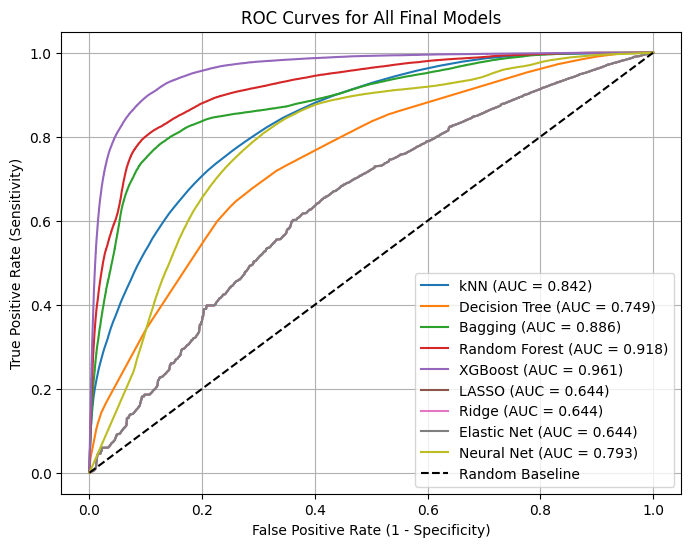

In [ ]:
# ROC CURVES - ALL MODELS

plt.figure(figsize=(8,6))
y_true = valid_y.values

for name, model in final_models.items():
    y_prob = model.predict_proba(valid_X)[:, 1]  # P(default = 1)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1], [0,1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for All Final Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

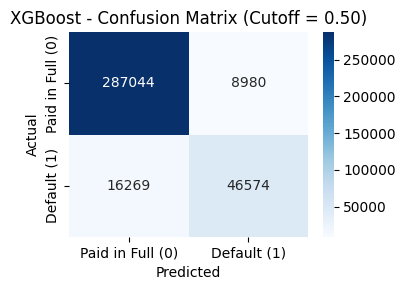

In [ ]:
# Confusion matrix heatmat _ best model (XgBoost)

chosen_name = 'XGBoost'
chosen_model = final_models[chosen_name]

y_prob = chosen_model.predict_proba(valid_X)[:,1]
y_pred = (y_prob >= 0.50).astype(int)

cm = confusion_matrix(valid_y, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Paid in Full (0)', 'Default (1)'],
            yticklabels=['Paid in Full (0)', 'Default (1)'])
plt.title(f'{chosen_name} - Confusion Matrix (Cutoff = 0.50)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


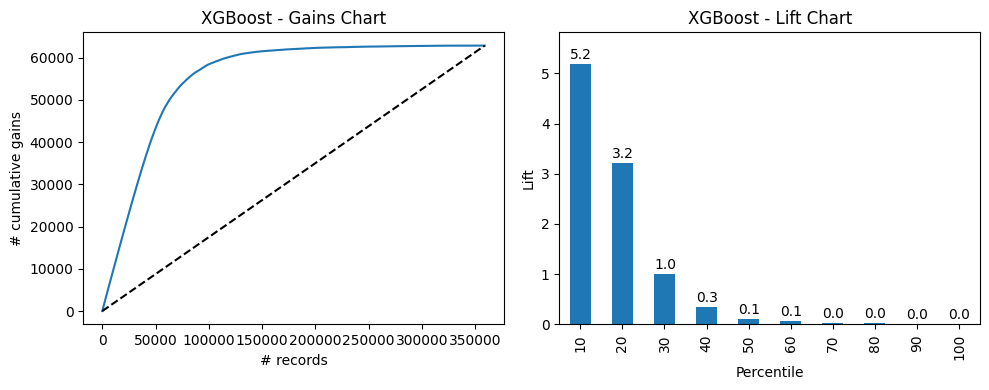

In [ ]:
# Gains and Lift charts

df_eval = pd.DataFrame({
    'actual': valid_y,
    'prob': chosen_model.predict_proba(valid_X)[:,1]
}).sort_values(by='prob', ascending=False)

fig, axes = plt.subplots(1,2, figsize=(10,4))

gainsChart(df_eval['actual'], ax=axes[0])
axes[0].set_title(f'{chosen_name} - Gains Chart')

liftChart(df_eval['actual'], title=False, ax=axes[1])
axes[1].set_title(f'{chosen_name} - Lift Chart')

plt.tight_layout()
plt.show()

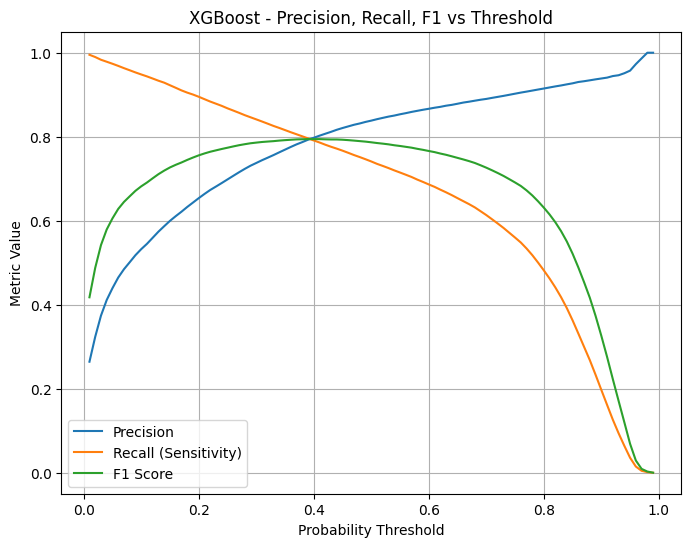

In [ ]:
# Precision, recall , f1 vs Probability cutoff

y_prob = chosen_model.predict_proba(valid_X)[:,1]
thresholds = np.linspace(0.01, 0.99, 99)

precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        valid_y, y_pred_t, average='binary', zero_division=0
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall (Sensitivity)')
plt.plot(thresholds, f1s, label='F1 Score')

plt.xlabel('Probability Threshold')
plt.ylabel('Metric Value')
plt.title(f'{chosen_name} - Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Profit function

def evaluate_model_profit(name, model, valid_X, valid_y, disbursement_series,
                          profit_rate=0.05, loss_multiplier=5):

    # Probability of default
    prob_default = model.predict_proba(valid_X)[:, 1]
    actual = valid_y.values
    loan_amount = disbursement_series.values

    # Per-loan profit
    profit_if_paid    = profit_rate * loan_amount
    profit_if_default = -loss_multiplier * profit_if_paid

    cutoffs = np.linspace(0.0, 1.0, 101)

    best_cutoff = None
    best_profit = -np.inf
    profit_curve = []

    for c in cutoffs:
        # grant loans whose predicted default prob is at or below the cutoff
        grant = prob_default <= c

        profit = np.where(
            grant & (actual == 0), profit_if_paid,
            np.where(grant & (actual == 1), profit_if_default, 0.0)
        )

        total_profit = profit.sum()
        profit_curve.append((c, total_profit))

        if total_profit > best_profit:
            best_profit = total_profit
            best_cutoff = c

    print(f"\n{name}:")
    print(f"  Best DEFAULT cutoff = {best_cutoff:.2f}")
    print(f"  Max net profit = ${best_profit:,.2f}")

    return {
        'model': name,
        'best_cutoff': best_cutoff,
        'max_profit': best_profit,
        'profit_curve': profit_curve
    }

In [ ]:
# Profit Evalutaion

disb_valid = model_df.loc[valid_y.index, 'DisbursementGross']

profit_results = []
for name, model in final_models.items():
    res = evaluate_model_profit(name, model, valid_X, valid_y, disb_valid)
    profit_results.append(res)

# Which is best?
profit_summary = pd.DataFrame(profit_results)
print("\nNET PROFIT SUMMARY")
display(profit_summary)


best_idx = profit_summary['max_profit'].idxmax()
best_model = profit_summary.loc[best_idx]

print("\nBEST MODEL BY NET PROFIT")
print("Model:", best_model['model'])
print("Max Net Profit: $", f"{best_model['max_profit']:,.2f}")
print("Optimal DEFAULT cutoff:", round(best_model['best_cutoff'], 2))


kNN:
  Best DEFAULT cutoff = 0.16
  Max net profit = $1,727,321,528.05

Decision Tree:
  Best DEFAULT cutoff = 0.17
  Max net profit = $1,511,711,740.85

Bagging:
  Best DEFAULT cutoff = 0.17
  Max net profit = $2,036,265,624.70

Random Forest:
  Best DEFAULT cutoff = 0.14
  Max net profit = $2,221,872,515.40

XGBoost:
  Best DEFAULT cutoff = 0.15
  Max net profit = $2,542,332,378.20

LASSO:
  Best DEFAULT cutoff = 0.35
  Max net profit = $1,314,673,821.35

Ridge:
  Best DEFAULT cutoff = 0.35
  Max net profit = $1,314,673,821.35

Elastic Net:
  Best DEFAULT cutoff = 0.35
  Max net profit = $1,314,665,675.50

Neural Net:
  Best DEFAULT cutoff = 0.27
  Max net profit = $1,521,783,942.65

NET PROFIT SUMMARY


,model,best_cutoff,max_profit,profit_curve
0,kNN,0.16,1.727322e+09,"[(0.0, 717879729.1), (0.01, 817101561.3), (0.0..."
1,Decision Tree,0.17,1.511712e+09,"[(0.0, 120289500.69999997), (0.01, 292790047.0..."
2,Bagging,0.17,2.036266e+09,"[(0.0, 0.0), (0.01, 0.0), (0.02, 40306500.0), ..."
3,Random Forest,0.14,2.221873e+09,"[(0.0, 0.0), (0.01, 242563430.0), (0.02, 45578..."
4,XGBoost,0.15,2.542332e+09,"[(0.0, 0.0), (0.01, 1403377217.85), (0.02, 177..."
5,LASSO,0.35,1.314674e+09,"[(0.0, 0.0), (0.01, 731183727.8499999), (0.02,..."
6,Ridge,0.35,1.314674e+09,"[(0.0, 0.0), (0.01, 731151452.8499999), (0.02,..."
7,Elastic Net,0.35,1.314666e+09,"[(0.0, 0.0), (0.01, 730996227.8499999), (0.02,..."
8,Neural Net,0.27,1.521784e+09,"[(0.0, 68436.1), (0.01, 635305050.2500002), (0..."



BEST MODEL BY NET PROFIT
Model: XGBoost
Max Net Profit: $ 2,542,332,378.20
Optimal DEFAULT cutoff: 0.15


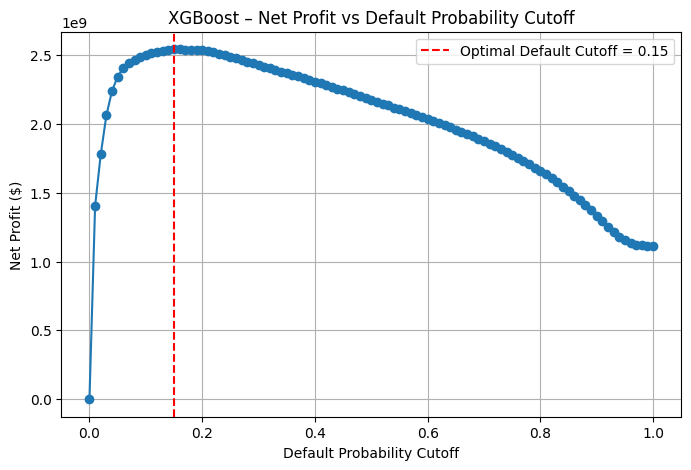

In [ ]:
# XGBoost PROFIT CURVE PLOT

xgb_res = [res for res in profit_results if res['model'] == 'XGBoost'][0]

# profit_curve
cutoffs = [c for c, p in xgb_res['profit_curve']]
profits = [p for c, p in xgb_res['profit_curve']]

plt.figure(figsize=(8,5))
plt.plot(cutoffs, profits, marker='o')

# Add optimal cutoff line
plt.axvline(
    x=xgb_res['best_cutoff'],
    color='r',
    linestyle='--',
    label=f'Optimal Default Cutoff = {xgb_res["best_cutoff"]:.2f}'
)

plt.title("XGBoost – Net Profit vs Default Probability Cutoff")
plt.xlabel("Default Probability Cutoff")
plt.ylabel("Net Profit ($)")
plt.legend()
plt.grid(True)
plt.show()


Which model produces the highest net profit?

Using the project’s asymmetric cost structure , I computed net profit for each model across probability cutoffs. XGBoost produced the highest overall net profit, approximately $2.54 billion on the validation set, outperforming Random Forest, Neural Network, Bagging, Logistic Regression, and kNN. Its strong AUC (0.961) allowed it to rank borrowers effectively and focus approvals on the safest, most profitable loans.

a) How far into the validation data should we go to achieve maximum net profit?

The profit curve shows that maximum profit occurs when we approve loans only for borrowers whose predicted probability of default is at or below approximately 0.15. This means that once predicted default risk exceeds 15%, additional loan approvals reduce profit because the expected loss from defaults outweighs the potential gain. Approving loans beyond this cutoff results in substantially lower profitability.

(b) What probability cutoff should be used for future applicants?

Based on the profit-maximizing threshold, the recommended approval rule is to grant loans only when the predicted probability of default is ≤ 0.15. This cutoff best balances expected earnings with the cost of mistakenly approving high risk borrowers and maximizes expected profitability for the bank.